## 1. Packages

In [1]:
import os
import pandas as pd
import numpy as np

%matplotlib inline
import src.upload_utils as ut
import constants as const
import src.draw_utils as du
import src.upload_yolo_utils as yu
import src.yolo_utils as yolo_utils

In [31]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

## 2. Data

### 2.1 Load data from GoogleDrive and unzip

In [2]:
ut.download_file_from_google_drive(id=const.FILE_ID, 
                                   destination=const.DATA_ZIP)

[{upload_utils.py:186} INFO - response = <Response [200]>
[{upload_utils.py:205} INFO - Start download file, size = 0


data.zip: 105MB [00:00, 119MB/s]  


In [3]:
ut.unzip_data(zip_file=const.DATA_ZIP)

[{upload_utils.py:225} INFO - Unzip = data.zip
[{upload_utils.py:228} INFO - Successfully unzip


### 2.2. Load data

In [4]:
mri_df_raw = ut.load_data(from_dir=const.PATH_FILES)

[{upload_utils.py:29} INFO - Load from /home/ubuntu/MRI_yolo/data/descr/ 12 files
[{upload_utils.py:34} INFO - Concat list of data frames
[{upload_utils.py:38} INFO - Finish read df = (916, 20)


### 2.3. Data exploration

In [5]:
mri_df_raw.head()

,ID,Исследователь,Кейс,Файлы,Протокол,XML,Файлы разметки,На срезе визуализируются межпозвоночные диски,Шейный межпозвоночный диск - здоровый,Шейный межпозвоночный диск - с подозрением на патологию,Шейный межпозвоночный диск - патологический,грудной межпозвоночный диск - здоровый,грудной межпозвоночный диск - с подозрением на паталогию,грудной межпозвоночный диск - патологический,поясничный межпозвоночный диск - здоровый,поясничный межпозвоночный диск - с подозрением на патологию,поясничный межпозвоночный диск - патологический,крестцовый межпозвоночный диск - здоровый,крестцовый межпозвоночный диск - с подозрением на патологию,крестцовый межпозвоночный диск - патологический
0,2872,Denis Shpak,4773 - dcm-dromanov,img_00215.jpg/n,MRI_NECK_SAG_prot_hern,<annotation>\r\n <filename>https://...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3144,Denis Shpak,4774 - dcm-dromanov,img_00226.jpg/n,MRI_NECK_SAG_prot_hern,<annotation>\r\n <filename>https://...,NaN,Визуализируются (можно размечать),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5571,Denis Shpak,4791 - dcm-dromanov,img_00200.jpg/n,MRI_NECK_SAG_prot_hern,NaN,NaN,Визуализируются (можно размечать),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5572,Denis Shpak,4791 - dcm-dromanov,img_00200.jpg/n,MRI_NECK_SAG_prot_hern,NaN,NaN,Визуализируются (можно размечать),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5573,Denis Shpak,4791 - dcm-dromanov,img_00200.jpg/n,MRI_NECK_SAG_prot_hern,NaN,NaN,Визуализируются (можно размечать),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
mri_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 20 columns):
ID                                                             916 non-null int64
Исследователь                                                  916 non-null object
Кейс                                                           916 non-null object
Файлы                                                          916 non-null object
Протокол                                                       916 non-null object
XML                                                            892 non-null object
Файлы разметки                                                 0 non-null float64
На срезе визуализируются межпозвоночные диски                  896 non-null object
Шейный межпозвоночный диск - здоровый                          0 non-null float64
Шейный межпозвоночный диск - с подозрением на патологию        0 non-null float64
Шейный межпозвоночный диск - патологический                    0 non-

In [7]:
mri_df_raw['На срезе визуализируются межпозвоночные диски'].value_counts()

Не визуализируются (срез не пригоден для разметки)    531
Визуализируются (можно размечать)                     365
Name: На срезе визуализируются межпозвоночные диски, dtype: int64

In [8]:
mri_df_raw = mri_df_raw[mri_df_raw['На срезе визуализируются межпозвоночные диски'] == 'Визуализируются (можно размечать)']

#### We can see columns with trash (all rows is null) and columns which we need to delete. Let's start data preprocessing (include XML parsing)

In [9]:
mri_preproc = ut.parse_xml(df=mri_df_raw)
mri_preproc.head()

[{upload_utils.py:78} INFO - Start preprocessing data, shape = (365, 20)
[{upload_utils.py:79} INFO - Drop NaN columns of XML
[{upload_utils.py:84} INFO - Start parse XML, shape = (356, 20)


,date,deleted,file,height,id,imagesize,name,occluded,parts,verified,width,x,x_center,y,y_center
0,28-Aug-2018 10:10:28,0,img_00226.jpg,12,3144,"384, 384",shejnyj-mezhpozvonochnyj-disk-zdorovyj,no,"0 {'hasparts': None, 'ispartof': None}\n1 ...",0,29,172,186.5,107,113.0
1,28-Aug-2018 10:10:35,0,img_00226.jpg,12,3144,"384, 384",shejnyj-mezhpozvonochnyj-disk-zdorovyj,no,"0 {'hasparts': None, 'ispartof': None}\n1 ...",0,25,168,180.5,132,138.0
2,28-Aug-2018 10:10:41,0,img_00226.jpg,12,3144,"384, 384",shejnyj-mezhpozvonochnyj-disk-zdorovyj,no,"0 {'hasparts': None, 'ispartof': None}\n1 ...",0,24,164,176.0,156,162.0
3,28-Aug-2018 10:27:23,0,img_00226.jpg,16,3144,"384, 384",shejnyj-mezhpozvonochnyj-disk-patologicheskij,no,"0 {'hasparts': None, 'ispartof': None}\n1 ...",0,25,164,176.5,178,186.0
4,28-Aug-2018 10:27:41,0,img_00226.jpg,19,3144,"384, 384",shejnyj-mezhpozvonochnyj-disk-zdorovyj,no,"0 {'hasparts': None, 'ispartof': None}\n1 ...",0,27,165,178.5,203,212.5


#### We can see a lot of columns. But we can drop a few columns because they don't contain information.
We should research: `imagesize`, `name`, `verified`, `occluded`, `deleted`, `date`

In [10]:
mri_preproc.id = mri_preproc.id.astype(object)

In [11]:
mri_preproc.describe(include=np.object)

,date,deleted,file,id,imagesize,name,occluded,parts,verified
count,1577,2694,2694,2694,2694,2694,2694,2694,2694
unique,1577,2,356,356,2,8,1,12,1
top,17-Sep-2018 11:15:37,0,img_00370.jpg,3928,"384, 384",shejnyj-mezhpozvonochnyj-disk-zdorovyj,no,"0 {'hasparts': None, 'ispartof': None}\n1 ...",0
freq,1,2676,13,13,2675,961,2694,700,2694


Let's see how much class in `deleted` and `imagesize`. Can we leave only one class? (We can see below, that yes)

We can see that `verified`, `occluded`, `parts`, `date` are not information. 

Function `preproc_data(df)` filters our data:
* **deleted** = 0
* **imagesize** = 384, 384
* **type_mri** = shejnyj

In [12]:
mri_filter, cat_label = ut.preproc_data(df=mri_preproc, columns=const.COLUMNS)

mri_filter.head()

[{upload_utils.py:148} INFO - Adding column type_mri
[{upload_utils.py:151} INFO - Stats by type_mri {'shejnyj': 1702, 'grudnoj': 990, 'protrusion': 1, 'hernia': 1}
[{upload_utils.py:152} INFO - Stats by deleted {'0': 2676, '1': 18}
[{upload_utils.py:153} INFO - Stats by imagesize {'384, 384': 2675, '512, 512': 19}
[{upload_utils.py:155} INFO - Filtering data, shape before = (2694, 16)
[{upload_utils.py:160} INFO - Adding column type of disk
[{upload_utils.py:163} INFO - Adding column label (category)
[{upload_utils.py:168} INFO - Filtering data, shape before = (1665, 18)
[{upload_utils.py:169} INFO - Category {0: 'patologicheskij', 1: 'spodozreniem', 2: 'zdorovyj'}
[{upload_utils.py:170} INFO - Filter by columns: id, label, file, type_disk, height, width, x, y, x_center, y_center


,id,label,file,type_disk,height,width,x,y,x_center,y_center
0,3144,2,img_00226.jpg,zdorovyj,12,29,172,107,186.5,113.0
1,3144,2,img_00226.jpg,zdorovyj,12,25,168,132,180.5,138.0
2,3144,2,img_00226.jpg,zdorovyj,12,24,164,156,176.0,162.0
3,3144,0,img_00226.jpg,patologicheskij,16,25,164,178,176.5,186.0
4,3144,2,img_00226.jpg,zdorovyj,19,27,165,203,178.5,212.5


### 2.4. Stats by clean data

In [13]:
mri_filter.describe(include=np.object)

,id,label,file,type_disk
count,1665,1665,1665,1665
unique,339,3,339,3
top,5590,2,img_00200.jpg,zdorovyj
freq,8,935,8,935


In [14]:
mri_filter.describe()

,height,width,x,y,x_center,y_center
count,1665.000000,1665.000000,1665.000000,1665.000000,1665.000000,1665.000000
mean,19.799399,37.666667,159.067267,162.058258,177.900601,171.957958
std,4.242995,6.972301,21.081807,42.243679,20.562241,42.514640
min,9.000000,19.000000,106.000000,57.000000,124.500000,69.000000
25%,17.000000,33.000000,144.000000,131.000000,163.500000,140.000000
50%,19.000000,38.000000,159.000000,163.000000,177.000000,172.500000
75%,22.000000,42.000000,173.000000,193.000000,192.500000,203.500000
max,51.000000,70.000000,214.000000,345.000000,229.500000,356.000000


Distribution of out class:

In [15]:
mri_filter['type_disk'].value_counts()

zdorovyj           935
patologicheskij    400
spodozreniem       330
Name: type_disk, dtype: int64

Good!

## 3. Draw

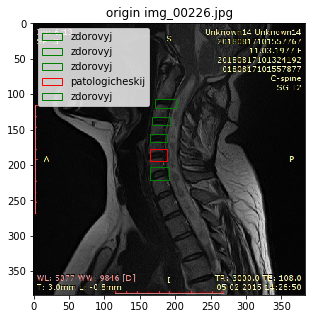

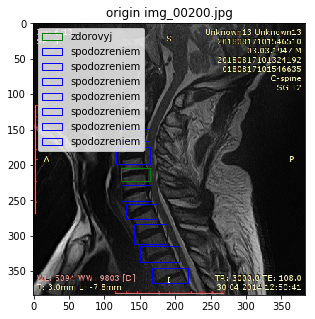

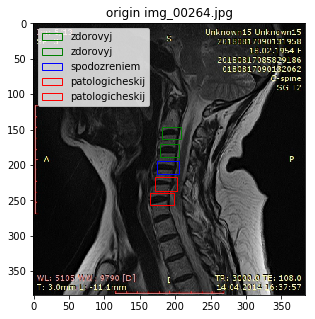

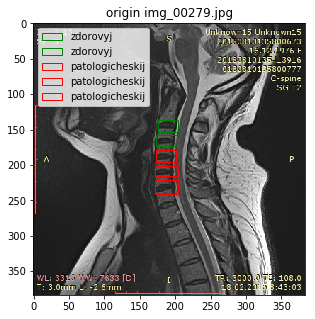

In [16]:
for img in mri_filter['file'].unique()[0:4]:
    plots = du.draw_img(df=[mri_filter], 
                        img_name=img,
                        types_df=['origin'],
                        dir_img=const.PATH_IMG, 
                        color_patch={'0': 'r', '1': 'b', '2': 'g'}, 
                        figsize=(5, 5))

In [17]:
unique_files = mri_filter['file'].unique()

In [18]:
N = len(unique_files)
TEST_NUM = int(0.3*N)

## 4. Prepare data for yolo

### 4.1. Copy obj.names and obj.data to data/

In [17]:
yu.copy_files(dir_from=const.ROOT + '/cfg/',
              dir_to=const.PATH_DARKNET + 'build/darknet/x64/data/',
              files=['obj.names', 'obj.data'])

[{upload_yolo_utils.py:28} INFO - Copy from /home/ubuntu/MRI_yolo/cfg/ 
 to 
 /home/ubuntu/MRI_yolo/darknet/build/darknet/x64/data/
[{upload_yolo_utils.py:34} INFO - Success copy 2 files


### 4.2. Copy cfg yolo.cfg to cfg/

In [18]:
yu.copy_files(dir_from=const.ROOT + '/cfg/',
              dir_to=const.PATH_DARKNET + 'build/darknet/x64/cfg/',
              files=['yolo.cfg'])

[{upload_yolo_utils.py:28} INFO - Copy from /home/ubuntu/MRI_yolo/cfg/ 
 to 
 /home/ubuntu/MRI_yolo/darknet/build/darknet/x64/cfg/
[{upload_yolo_utils.py:34} INFO - Success copy 1 files


### 4.3. Copy all images to data/obj (and create obj/ dir)

In [19]:
if not os.path.exists(const.PATH_DARKNET + 'build/darknet/x64/data/obj'):
    os.makedirs(const.PATH_DARKNET + 'build/darknet/x64/data/obj')

In [20]:
yu.copy_files(dir_from=const.PATH_IMG,
              dir_to=const.PATH_DARKNET + 'build/darknet/x64/data/obj',
              files=unique_files)

[{upload_yolo_utils.py:28} INFO - Copy from /home/ubuntu/MRI_yolo/data/images/ 
 to 
 /home/ubuntu/MRI_yolo/darknet/build/darknet/x64/data/obj
[{upload_yolo_utils.py:34} INFO - Success copy 339 files


### 4.4. Create for each images txt file with polygon (to data/obj)

In [56]:
yu.img_txt(df=mri_filter,
           dir_to=const.PATH_DARKNET + 'data/obj', 
           img_size=const.IMG_SIZE,
           columns_yolo=const.COLUMNS_YOLO,
           imgs=unique_files)

### 4.5. Copy create test and train images and save to data/

In [19]:
test_set, train_set = yu.test_train_files(imgs=unique_files, 
                                          test_size=TEST_NUM, 
                                          dir_to_file='data/obj/',
                                          dir_to=const.PATH_DARKNET + 'data/')

[{upload_yolo_utils.py:61} INFO - Write test file 101 to 
 /home/ubuntu/MRI_yolo/darknet/build/darknet/x64/data/
[{upload_yolo_utils.py:67} INFO - Write train file 238 to 
 /home/ubuntu/MRI_yolo/darknet/build/darknet/x64/data/


## 5. Evaluate

### 5.1. Change directory

In [20]:
const.WEIGHT_YOLO.format('1000')

'/home/ubuntu/MRI_yolo/darknet/build/darknet/x64/backup/yolo_1000.weights'

In [21]:
import os
os.chdir(const.PATH_DARKNET)

### 5.2. Load network (cfg, data, weight)

In [22]:
net, meta = yolo_utils.load_data(cfg=const.CFG_YOLO, 
                                 data=const.DATA_YOLO, 
                                 weights=const.WEIGHT_YOLO.format('16000'))

[{yolo_utils.py:185} INFO - Encode to ascii
[{yolo_utils.py:190} INFO - Load net b'/home/ubuntu/MRI_yolo/darknet/build/darknet/x64/cfg/yolo.cfg' b'/home/ubuntu/MRI_yolo/darknet/build/darknet/x64/backup/yolo_16000.weights'
[{yolo_utils.py:193} INFO - Load meta b'/home/ubuntu/MRI_yolo/darknet/build/darknet/x64/data/obj.data'


### 5.3. Create DataFrame for predict

In [23]:
def detect_df(net, meta, img, columns, cat_label, threshold=.2):
    detect_list = yolo_utils.detect(net=net,
                         meta=meta,
                         image=('data/obj/' + img).encode('ascii'),
                         thresh=threshold)
    results = pd.DataFrame(detect_list)
    if results.shape[0] == 0:
        return pd.DataFrame(columns=columns)
    results = results.drop(1, axis=1)
    results.columns = columns
    results['x'] = results['x_center'] - results['width'] / 2
    results['y'] = results['y_center'] - results['height'] / 2
    results['label'] = results['label'].astype(int) - 1
    results['type_disk'] = results['label'].map(cat_label)
    results['file'] = img
    return results

In [24]:
yolo_results_test_list = []
for i in range(len(test_set)):
    results = detect_df(net=net, 
                               meta=meta,
                               img=test_set[i],
                               cat_label=cat_label, 
                               columns=const.COLUMNS_YOLO,
                               threshold=.2)
    yolo_results_test_list.append(results)
yolo_results_test = pd.concat(yolo_results_test_list)

In [75]:
yolo_results_test.head()

,file,height,label,type_disk,width,x,x_center,y,y_center
0,img_00681.jpg,17.323145,2,zdorovyj,32.972569,185.613600,202.099884,128.055697,136.717270
0,img_01253.jpg,23.818659,0,patologicheskij,45.858677,156.234541,179.163879,233.539493,245.448822
0,img_00320.jpg,16.245529,2,zdorovyj,42.762299,137.472122,158.853271,201.228889,209.351654
1,img_00320.jpg,17.299450,0,patologicheskij,44.352444,136.184496,158.360718,224.228327,232.878052
2,img_00320.jpg,23.533701,0,patologicheskij,47.066109,134.413021,157.946075,249.232600,260.999451


### 5.4. Visualize results

In [25]:
mri_filter[mri_filter['file'] == 'img_01020.jpg']

,id,label,file,type_disk,height,width,x,y,x_center,y_center
1713,3033,2,img_01020.jpg,zdorovyj,26,38,173,81,192.0,94.0
1714,3033,2,img_01020.jpg,zdorovyj,21,39,172,112,191.5,122.5
1715,3033,2,img_01020.jpg,zdorovyj,22,38,168,138,187.0,149.0
1716,3033,2,img_01020.jpg,zdorovyj,13,39,166,163,185.5,169.5
1717,3033,2,img_01020.jpg,zdorovyj,23,36,165,186,183.0,197.5
1718,3033,2,img_01020.jpg,zdorovyj,22,40,163,214,183.0,225.0


In [26]:
yolo_results_test[yolo_results_test['file'] == 'img_01020.jpg']

,file,height,label,type_disk,width,x,x_center,y,y_center
0,img_01020.jpg,23.862246,2,zdorovyj,34.684635,173.459166,190.801483,83.631942,95.563065
1,img_01020.jpg,22.998255,2,zdorovyj,44.787354,166.982300,189.375977,109.422259,120.921387
2,img_01020.jpg,20.762667,2,zdorovyj,41.318096,172.224985,192.884033,97.230849,107.612183
3,img_01020.jpg,21.403664,2,zdorovyj,38.924713,167.925171,187.387527,137.661022,148.362854
4,img_01020.jpg,20.870724,2,zdorovyj,39.820744,165.069273,184.979645,163.841021,174.276382
5,img_01020.jpg,20.731932,2,zdorovyj,44.826534,159.585909,181.999176,190.541993,200.907959
6,img_01020.jpg,17.372231,2,zdorovyj,43.833611,158.892780,180.809586,216.443569,225.129684


In [29]:
top_img = mri_filter.groupby('file')['file'].count().sort_values(ascending=False).head()

<IPython.core.display.Javascript object>

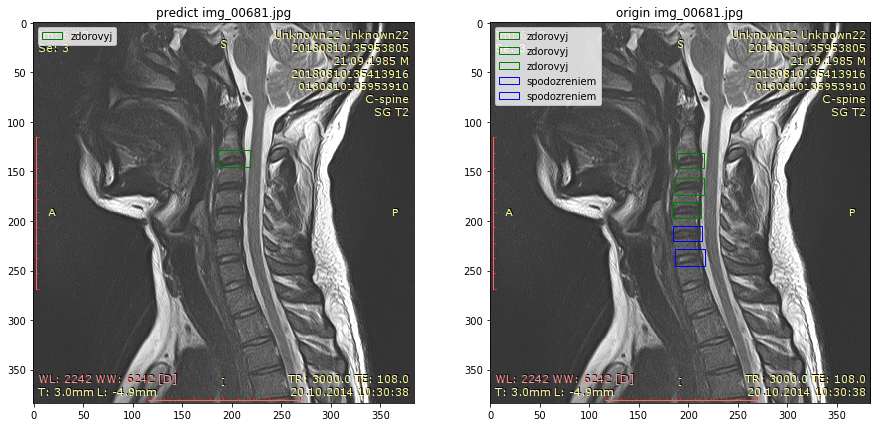

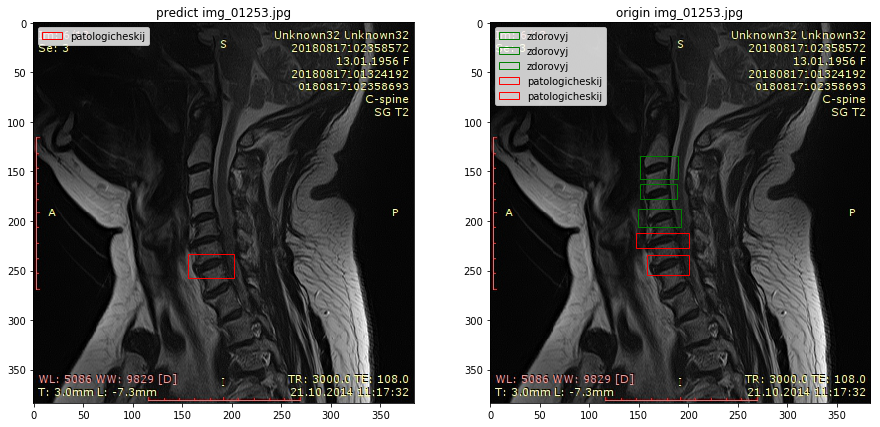

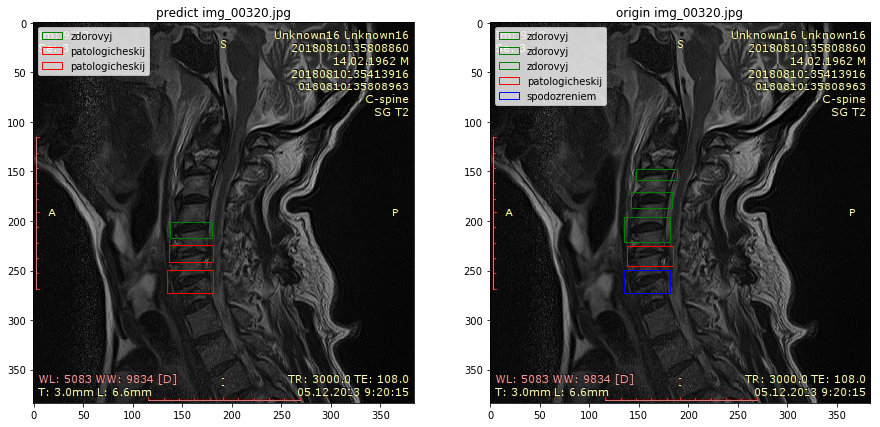

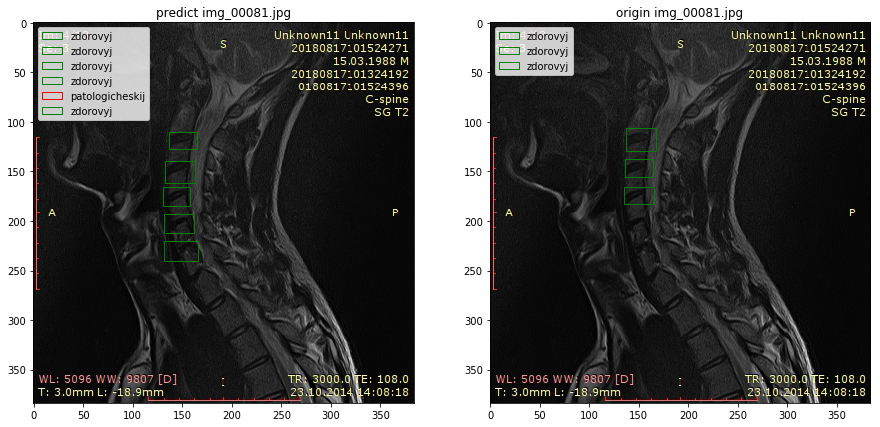

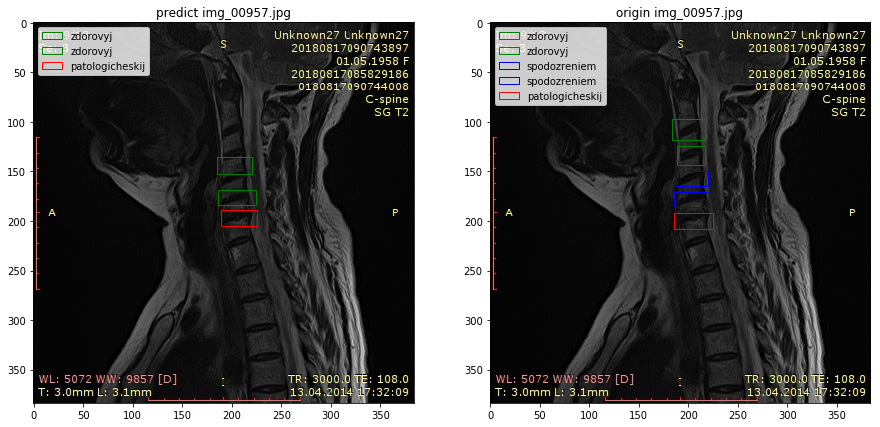

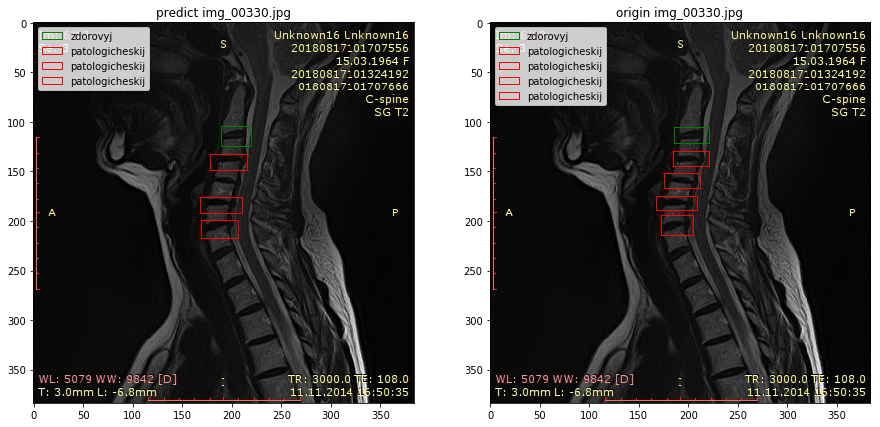

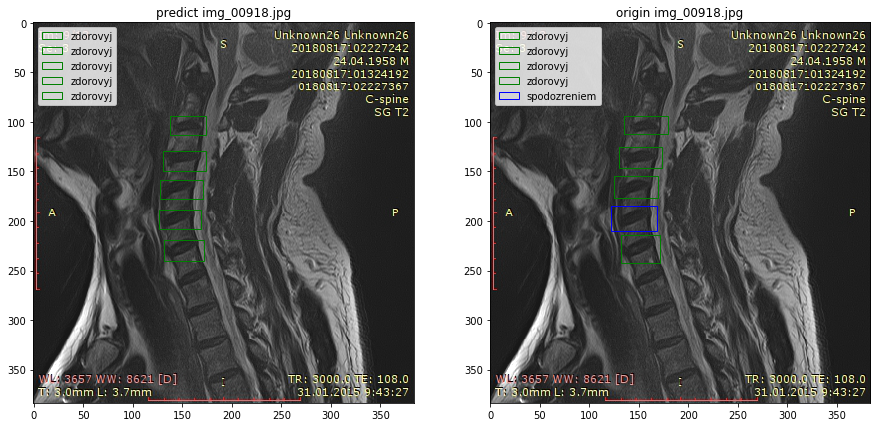

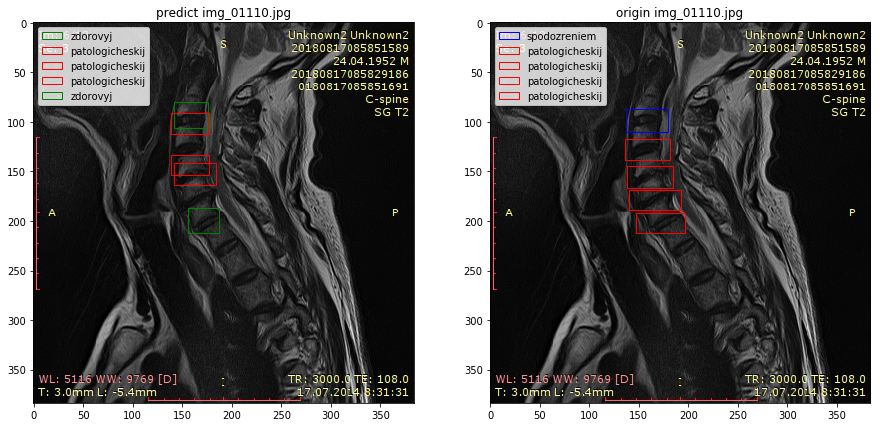

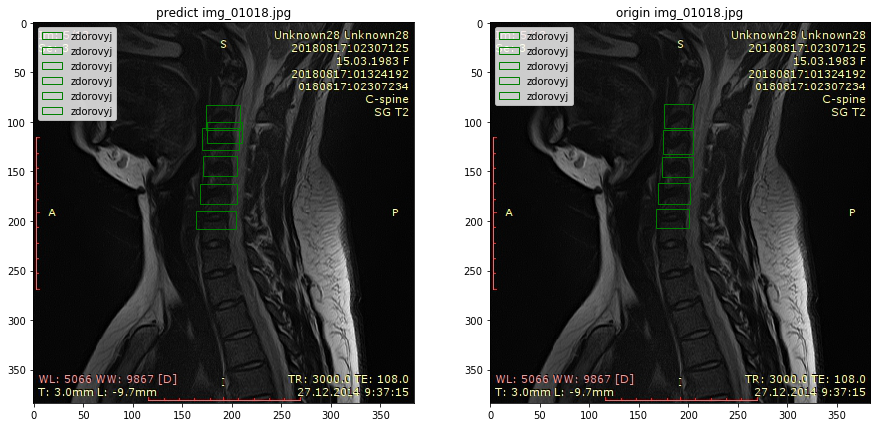

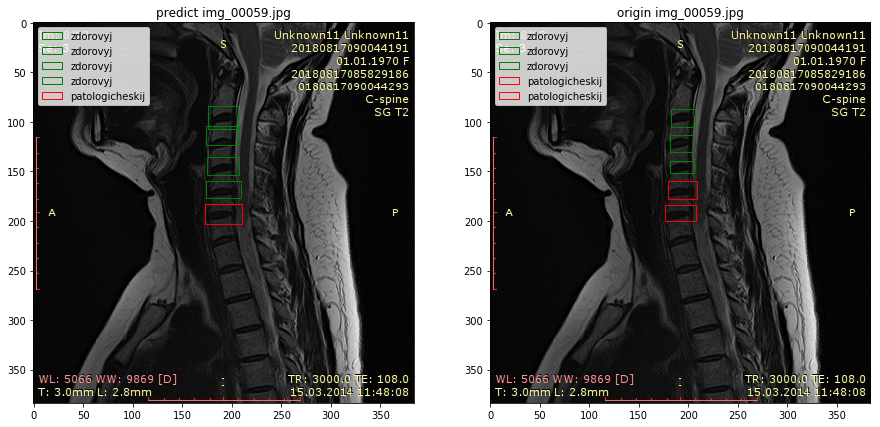

In [34]:
for i in test_set[0:10]:
    du.draw_img(df=[yolo_results_test, mri_filter], 
             types_df = ['predict', 'origin'],
             img_name=i, 
             dir_img=const.PATH_IMG, 
             figsize=(15, 15),
             color_patch={'0': 'r', '1': 'b', '2': 'g'})

In [44]:
def sign(x):
    if x>=0: return 1
    else: return -1

In [98]:
def get_IoU(boxA, boxB):
    
    
    if boxA['type_disk'] != boxB['type_disk']: 
        return 0

    xA, yA, wA, hA = (boxA['x'], boxA['y'], boxA['width'], boxA['height'])
    xB, yB, wB, hB = (boxB['x'], boxB['y'], boxB['width'], boxB['height'])
    
    tx = sign(xB - xA)
    ty = sign(yB - yA)

    Ix = (wA/2 + wB/2 + tx*(xA - xB))
    Iy = (hA/2 + hB/2 + ty*(yA - yB))
    
    Ix = max(0, min(xA + wA, xB + wB) - max(xA, xB))
    Iy = max(0, min(yA + hA, yB + hB) - max(yA, yB))

    I = Ix*Iy
    
    U = wA*hA + wB*hB - I
    return I/U

In [143]:
img_pred = yolo_results_test[yolo_results_test['file'] == 'img_00059.jpg'].copy().reset_index()
img_origin = mri_filter[mri_filter['file'] == 'img_00059.jpg'].copy().reset_index()

In [144]:
img_pred

,index,file,height,label,type_disk,width,x,x_center,y,y_center
0,0,img_00059.jpg,22.318689,2,zdorovyj,30.515327,175.711086,190.968750,84.411838,95.571182
1,1,img_00059.jpg,19.694386,2,zdorovyj,33.027313,173.836868,190.350525,103.850477,113.697670
2,2,img_00059.jpg,17.981077,2,zdorovyj,31.458954,175.281250,191.010727,135.492417,144.482956
3,3,img_00059.jpg,17.172712,2,zdorovyj,35.102383,173.882311,191.433502,159.962777,168.549133
4,4,img_00059.jpg,20.359983,0,patologicheskij,37.664902,172.419151,191.251602,183.099580,193.279572


In [164]:
iou_list = []

img_origin_list = []

for img in ['img_00059.jpg']:
    img_pred = yolo_results_test[yolo_results_test['file'] == img].copy().reset_index()
    img_origin = mri_filter[mri_filter['file'] == img].copy().reset_index()
    img_origin['iou'] = 0.0
    for i in range(img_origin.shape[0]):
        iou = []
        for j in range(img_pred.shape[0]):
            iou.append(get_IoU(boxA=img_origin.iloc[i,:], 
                               boxB=img_pred.iloc[j,:]))
        img_origin['iou'][i] = max(iou)
    img_origin_list.append(img_origin)
    
mri_metrics = pd.concat(img_origin_list, axis=1)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [161]:
mri_metrics

,index,id,label,file,type_disk,height,width,x,y,x_center,y_center,iou
0,141,5110,2,img_00059.jpg,zdorovyj,18,25,182,87,194.5,96.0,0.627459
1,142,5110,2,img_00059.jpg,zdorovyj,17,24,181,113,193.0,121.5,0.314234
2,143,5110,2,img_00059.jpg,zdorovyj,13,25,181,139,193.5,145.5,0.574544
3,144,5110,0,img_00059.jpg,patologicheskij,18,30,179,160,194.0,169.0,0.000000
4,145,5110,0,img_00059.jpg,patologicheskij,16,32,176,184,192.0,192.0,0.667661


0    0.627459
1    0.314234
2    0.574544
3    0.000000
4    0.667661
Name: IoU, dtype: float64

In [142]:
img_origin

,index,id,label,file,type_disk,height,width,x,y,x_center,y_center,IoU
0,141,5110,2,img_00059.jpg,zdorovyj,18,25,182,87,194.5,96.0,0.0
1,142,5110,2,img_00059.jpg,zdorovyj,17,24,181,113,193.0,121.5,0.0
2,143,5110,2,img_00059.jpg,zdorovyj,13,25,181,139,193.5,145.5,0.0
3,144,5110,0,img_00059.jpg,patologicheskij,18,30,179,160,194.0,169.0,0.0
4,145,5110,0,img_00059.jpg,patologicheskij,16,32,176,184,192.0,192.0,0.0
